**Project "APP 'Products'". Analysis of A/A/B test results**

We have data on the user behavior of the mobile app of a startup that sells food. Based on the available data, we will study user behavior.

Let's study the sales funnel. Find out how users reach a purchase. How many users reach the purchase, and how many “remain” in the previous steps? Which ones exactly?


**The main goal of the project** is to rate the sales funnel based on A/A/B tests. We need to find out which of the tested fonts increases sales. During the analysis, we must find additional parameters for evaluating the effectiveness of fonts.

Input data:

ExpId is the number of the experiment: 
- 246 and 247 are the control groups
- 248 is the experimental group

Events under study: Main Screen, Offer Screen, Payment Screen, Payment Confirmation, Tuttorial


**Project structure:**

1. Download data
2. Data preparation
3. Examining and validating data
4. Studying the sales funnel (events)
5. Sales Funnel Charts (Events)
6. Studying the results of the experiment
7. General results

### 1. Download data

In [1]:
# download libraries

import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string as str
from collections import Counter
from scipy import stats as st
import scipy.stats as stats

import math as mth
from statsmodels.stats.multitest import multipletests

import warnings
warnings.filterwarnings("ignore")

# sales funnel charts
from plotly import graph_objects as go


In [2]:
# getting name of DF file after download
import os

# download data, using separator

# download data from server or local host
# attempt_1 - the way and the mane of the file for download from server 
# attempt_2 - the way and the mane of the file for download from local

attempt_1 ='https://code.s3.yandex.net/datasets/logs_exp.csv'
attempt_2 ='C://yandex_data_sets/08_logs_exp.csv'

# getting name of the file
name_os_data = os.path.basename(attempt_1)
print('File name:',name_os_data)

# error processing when you uploading a file
try:
    data = pd.read_csv(attempt_1, sep='\t') 
    print(name_os_data, 'has been downloaded from the server')
except:
    print('Server error')
try:
    data = pd.read_csv(attempt_2, sep='\t') 
    print(name_os_data, 'has been downloaded from local host')
except:
    print('Local Error')



File name: logs_exp.csv
logs_exp.csv has been downloaded from the server
logs_exp.csv has been downloaded from local host


In [3]:
# look at the data

display(data.head(3))
data.describe()
data.info()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


## 2. Data preparation

In [4]:
# change forma of datetime

data['EventTimestamp'] = pd.to_datetime(data['EventTimestamp'], unit='s')

In [5]:
display(data.head(3))

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248


In [6]:
# change titles

data.rename(columns = {'EventName':'event_name','DeviceIDHash':'device_id','ExpId':'exp_id'}, inplace = True)

In [7]:
# check titles
data.columns.values

array(['event_name', 'device_id', 'EventTimestamp', 'exp_id'],
      dtype=object)

In [8]:
# add a new column event_date with out time
data['event_date']=data['EventTimestamp'].dt.strftime('%Y-%m-%d')
display(data.head(3))

,event_name,device_id,EventTimestamp,exp_id,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25


In [9]:
# count the duplicates
print('Duplicates data', data.duplicated().sum())

Duplicates data 413


In [10]:
# looking at duplicates
dubble = data[data.duplicated()]
display(dubble)

,event_name,device_id,EventTimestamp,exp_id,event_date
453,MainScreenAppear,5613408041324010552,2019-07-30 08:19:44,248,2019-07-30
2350,CartScreenAppear,1694940645335807244,2019-07-31 21:51:39,248,2019-07-31
3573,MainScreenAppear,434103746454591587,2019-08-01 02:59:37,248,2019-08-01
4076,MainScreenAppear,3761373764179762633,2019-08-01 03:47:46,247,2019-08-01
4803,MainScreenAppear,2835328739789306622,2019-08-01 04:44:01,248,2019-08-01
...,...,...,...,...,...
242329,MainScreenAppear,8870358373313968633,2019-08-07 19:26:44,247,2019-08-07
242332,PaymentScreenSuccessful,4718002964983105693,2019-08-07 19:26:45,247,2019-08-07
242360,PaymentScreenSuccessful,2382591782303281935,2019-08-07 19:27:29,246,2019-08-07
242362,CartScreenAppear,2382591782303281935,2019-08-07 19:27:29,246,2019-08-07


Without additional verification, it is difficult to understand what these duplicates are and the reasons for their appearance, because duplicates less than 1% will remove them

In [11]:
# delete duplicates
# with out drop=True the old column will remain index, will be dubble

data=data.drop_duplicates().reset_index(drop=True)

In [12]:
# count the duplicates
print('Duplicates data', data.duplicated().sum())

Duplicates data 0


**Conclusions on loading and preparing data:**

- changed date type
- removed duplicates

## Examining and validating data

### Events in log

In [13]:
# looking at events

display(data['event_name'].unique())

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

### Users in log

In [14]:
# looking at users

display(len(data['device_id'].unique()))

7551

### How many events for per user on average?

In [15]:
mean_users = data.pivot_table(index=['device_id'], values='event_name', aggfunc='count').reset_index()
mean_users.head(3)

,device_id,event_name
0,6888746892508752,1
1,6909561520679493,5
2,6922444491712477,47


In [16]:
mean_users.describe()

,device_id,event_name
count,7.551000e+03,7551.000000
mean,4.677319e+18,32.275593
std,2.655343e+18,65.154219
min,6.888747e+15,1.000000
25%,2.397700e+18,9.000000
50%,4.688022e+18,20.000000
75%,7.007353e+18,37.000000
max,9.222603e+18,2307.000000


On average, there are 32 events per user. Median 20. There are outliers. Maximum 2307

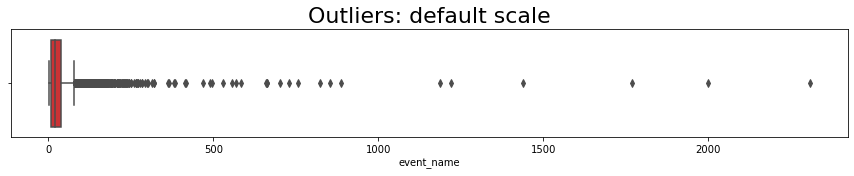

In [17]:
plt.figure(figsize=(15,2))
# set df and color
sns.boxplot(mean_users['event_name'], palette="Set1")

plt.title('Outliers: default scale', fontsize=22)
plt.show()

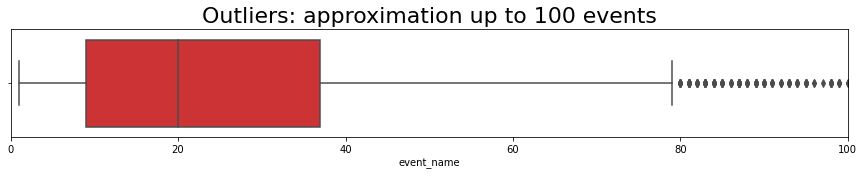

In [18]:
plt.figure(figsize=(15,2))
# set df and color
sns.boxplot(mean_users['event_name'], palette="Set1")
# set a limit
plt.xlim((0,100))
plt.title('Outliers: approximation up to 100 events', fontsize=22)
plt.show()

Based on the graph, it is possible to estimate the emissions from 80 events, consider the number of emissions

In [19]:
users_with_event_bigger_80 = mean_users.query('event_name >= 80')
len(users_with_event_bigger_80.query('event_name >= 80'))

494

There are 7555 users in total across all groups, outliers account for 494 users, they greatly change the picture, the average event, they should be removed, but this can greatly affect the realism of A / A groups. When analyzing the conversion, the removal of outliers is ineffective, because we do not count the number of events, but the fact of the occurrence of the event.

Let's leave the data as it is. However, for comparison, let's make a sales funnel with emissions of more than 80 events per user and without them.

### What period do we have data for?

In [20]:
print('Maximum date', data['event_date'].max())
print('Minimum date', data['event_date'].min())

Maximum date 2019-08-07
Minimum date 2019-07-25


In [21]:
display(data.head(3))

,event_name,device_id,EventTimestamp,exp_id,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25


### Build a histogram by date and time. 

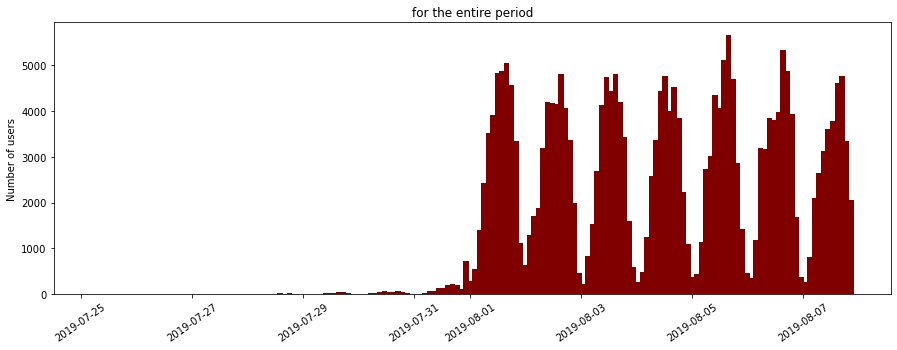

In [22]:
# the period when we started collecting logs and their distribution

date_users = data['EventTimestamp']

fig = plt.figure(figsize=(15, 5))
plt.hist(date_users, color='maroon', bins=7*24, width=0.1)
plt.ylabel('Number of users')
# plt.xlabel('Date')
plt.title('for the entire period')
plt.xticks(rotation = 35)
plt.show()


The graph shows that since 2019-08-01 there has been a sharp jump in the number of users. this is a startup, then most likely this is due to the launch of the product, before that it was most likely pre-production.

#### Determine from what point the data is complete and discard the older ones.

In [23]:
# looking at events

befor_2019_08_01=data.query('event_date < "2019-08-01"')
befor_2019_08_01['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

The list of events is the same as in all data, the events are complete.

In [24]:
# count of users
# use the length of the list of unique users
print('Count of users', len(befor_2019_08_01['device_id'].unique()))

Count of users 1451


In [25]:
# testing groups
befor_2019_08_01['exp_id'].unique()

array([246, 248, 247], dtype=int64)

We see that there are all three groups

#### Determine from what point the data is complete and discard the old ones.

Obviously, the data is complete: there are events, there are unique users, but since this period can be considered a test period, it is logical to assume that user behavior could differ greatly due to the operation of the application itself. Therefore, we will take the data from the moment the application was fully launched - 2019-08-01
    

In [26]:
# use filter
data_after = data.query('event_date >= "2019-08-01"')

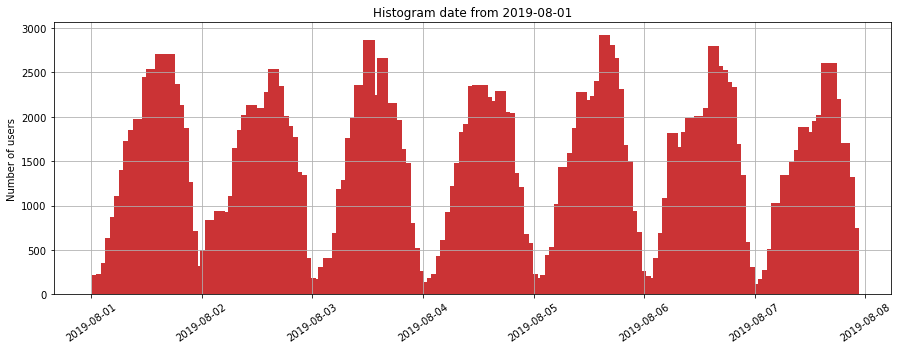

In [27]:
# events after filtering by date
date_users = data_after['EventTimestamp']

fig = plt.figure(figsize=(15, 5))
plt.hist(date_users, color='#CB3335', bins=7*24, width=0.1)
plt.ylabel('Number of users')
# plt.xlabel('Date')
plt.title('Histogram date from 2019-08-01')
plt.xticks(rotation = 35)
# turn on the grid
plt.grid(which='major')
plt.show()

#### What time period do we actually have data for?

In [28]:
print('Maximum date after filtering', data_after['event_date'].max())
print('Minimum date after filtering', data_after['event_date'].min())

Maximum date after filtering 2019-08-07
Minimum date after filtering 2019-08-01


We have a sample for 7 days. This is also clearly visible on the graph.

#### How many events and users have we lost by discarding old data?

In [29]:
# consider the amount of data before and after filtering
# use the length of the unique data

all_event = len(data['event_name'])
all_users = len(data['device_id'].unique())
all_group = len(data['exp_id'].unique())
all_event_after = len(data_after['event_name'])
all_users_after = len(data_after['device_id'].unique())
all_group_after = len(data_after['exp_id'].unique())


print('All events', all_event)
print('All users', all_users)
print('All group', all_group)
print()
print('Events in 7 days', all_event_after)
print('Users in 7 days', all_users_after)
print('Groups in 7 days', all_group_after)
print('Data loss:')
print('Events:', all_event - all_event_after, 'this is', f'{(all_event - all_event_after) /all_event :.2%}' )
print('Users:', all_users - all_users_after, 'this is', f'{(all_users - all_users_after) /all_users :.2%}' )
print('Groups:', all_group - all_group_after, 'this is', f'{(all_group - all_group_after) /all_group :.2%}' )

All events 243713
All users 7551
All group 3

Events in 7 days 240887
Users in 7 days 7534
Groups in 7 days 3
Data loss:
Events: 2826 this is 1.16%
Users: 17 this is 0.23%
Groups: 0 this is 0.00%


#### Let's check that we have users from all three experimental groups.

In [30]:
# lets group exp_id (groups) and device_id (users)

users = data.pivot_table(index=['exp_id'], values='device_id', aggfunc='nunique').reset_index().sort_values(by='device_id', ascending=False)
display(users)

,exp_id,device_id
2,248,2542
1,247,2520
0,246,2489


In [31]:
# lets group exp_id (groups) and device_id (users)
# after 2019-08-01
display(data_after.pivot_table(index=['exp_id'], values='device_id', aggfunc='nunique').reset_index().sort_values(by='device_id', ascending=False))

,exp_id,device_id
2,248,2537
1,247,2513
0,246,2484


In [32]:
# lets group exp_id (groups) and device_id (users)
# befor 2019-08-01
users_3 = befor_2019_08_01.pivot_table(index=['exp_id'], values='device_id', aggfunc='nunique').reset_index().sort_values(by='device_id', ascending=False)
display(users_3)

,exp_id,device_id
2,248,508
1,247,484
0,246,459


We have users in all three groups and for all periods.

### Remove users with more than 80 events.

In [33]:
# users with more than 80 events
display(users_with_event_bigger_80.head(3))

,device_id,event_name
4,7702139951469979,137
9,15708180189885246,126
58,77364241990273403,98


In [34]:
# create a table where the indexes will be the user ids that need to be deleted
good_ids = users_with_event_bigger_80.pivot_table(index='device_id', values='event_name')
print(len(good_ids))

494


In [35]:
# filter by values matching id in good_ids
data_users_bigger_80 = data_after.query('device_id not in @good_ids.index')
print('The ratio of filtered data to the remaining', round(len(data_users_bigger_80) / len(data), 3))

The ratio of filtered data to the remaining 0.657


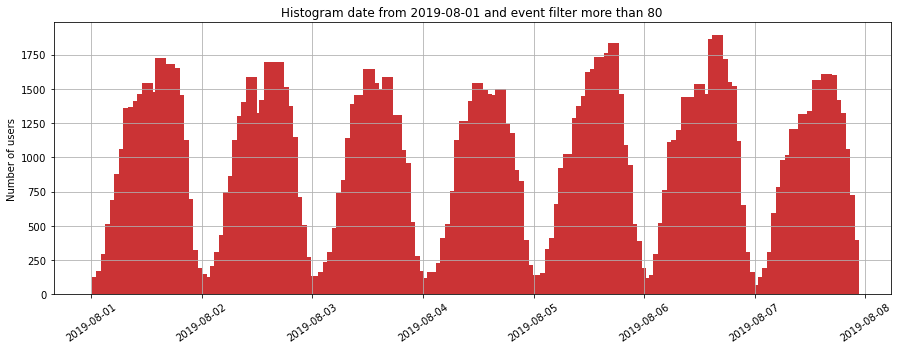

In [36]:
# events after filtering by date and events over 80
date_users = data_users_bigger_80['EventTimestamp']

fig = plt.figure(figsize=(15, 5))
plt.hist(date_users, color='#CB3335', bins=7*24, width=0.1)
plt.ylabel('Number of users')
# plt.xlabel('Date')
plt.title('Histogram date from 2019-08-01 and event filter more than 80')

# add a 35 degree rotation
plt.xticks(rotation = 35)

# turn on the grid
plt.grid(which='major')

plt.show()

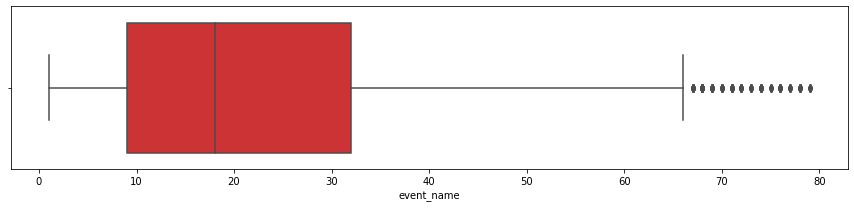

In [37]:
mean_users_bigger_80 = data_users_bigger_80.pivot_table(index=['device_id'], values='event_name', aggfunc='count').reset_index()

# emissions after filtration
plt.figure(figsize=(15,3))
sns.boxplot(mean_users_bigger_80['event_name'], palette="Set1");

In [38]:
# data after filtering by 80 events
mean_users_bigger_80.describe()

,device_id,event_name
count,7.040000e+03,7040.000000
mean,4.678303e+18,22.746023
std,2.658259e+18,17.774470
min,6.888747e+15,1.000000
25%,2.393722e+18,9.000000
50%,4.692496e+18,18.000000
75%,7.020374e+18,32.000000
max,9.222603e+18,79.000000


#### Conclusions on data preparation.

- left data for 7 days
- the number of users in the remaining groups is approximately the same
- less than 1% data is lost as a result of sampling by date
- according to the boxplot graph, it is clearly seen that after removing the outliers, there was a general averaging of the data: the outliers decreased, the mean and median approached the same value
- the number of users after filtering by 80 events has decreased, which is expected, it also visually reduced the maximum peaks, but in general the picture remained the same

### Exploring the sales funnel.

### Let's see what events are in the logs, how often they occur.

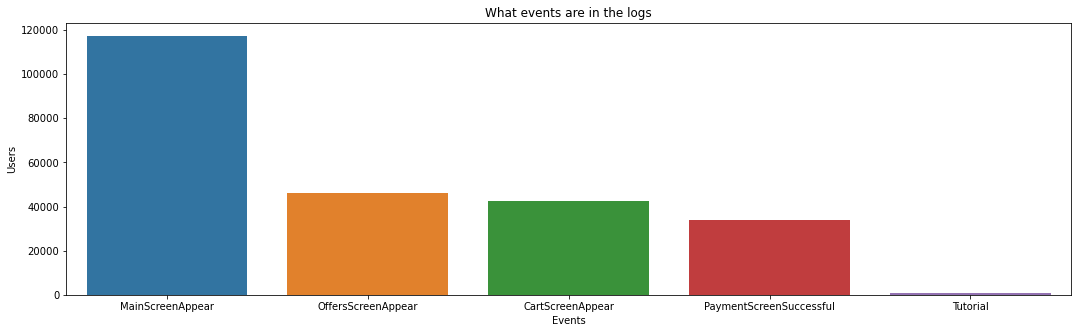

In [39]:
#create a pivot table with event_name as index
events_users = data_after.pivot_table(index=['event_name'], values='device_id', aggfunc='count').reset_index().sort_values(by='device_id', ascending=False)
plt.figure(figsize=(18, 5))
sns.barplot(data = events_users, x='event_name', y='device_id')
plt.ylabel('Users')
plt.xlabel('Events')
plt.title('What events are in the logs')
#plt.xticks(rotation = 90)
plt.show()

The graph shows that the events are arranged according to the classic sales funnel:
- main screen
- offer, less than 2 times
- card payment, slight delay
- payment completed successfully, slight backlog
- tutorial, it fits into the general scheme, although the tutorial is not directly related to other events, it can not be considered.

### Consider unique users and the ratio of their actions

In [40]:
# create pivot table event / user
event_unique=data_after.groupby('event_name')['device_id'].nunique().reset_index().sort_values(by='device_id', ascending=False)


In [41]:
# calculate the total number of unique users
count_of_customders = len(data_after['device_id'].unique())
print('Count of unique users', count_of_customders)

Count of unique users 7534


In [42]:
# ratio
event_unique['ratio']=(event_unique['device_id']/count_of_customders)*100

event_unique.style.format({'ratio': '{:.2f}%'})

,event_name,device_id,ratio
1,MainScreenAppear,7419,98.47%
2,OffersScreenAppear,4593,60.96%
0,CartScreenAppear,3734,49.56%
3,PaymentScreenSuccessful,3539,46.97%
4,Tutorial,840,11.15%


### In what order do events take place?

- main screen
- offer, less than 2 times
- card payment, slight delay
- payment completed successfully, slight backlog

The sequence of events then stops.
- tutorial, it fits into the general scheme, although the tutorial is not directly related to other events, it can not be considered. The last table shows that less than 5% of all users look at the tutorial.

### Sales funnel charts.

Let's look at data on users from all test groups

In [43]:
# calculate the ratio of the previous to the next use the shift() function
# what proportion of users go to the next step
event_unique['relations'] = event_unique['device_id']/event_unique['device_id'].shift()*100

# delete row at index 4 (Tutorial)
event_unique = event_unique.drop(index=[4])
display(event_unique.style.format({'share': '{:.2f}%',
                         'relations': '{:.2f}%'})
       )

,event_name,device_id,ratio,relations
1,MainScreenAppear,7419,98.473586,nan%
2,OffersScreenAppear,4593,60.963632,61.91%
0,CartScreenAppear,3734,49.561986,81.30%
3,PaymentScreenSuccessful,3539,46.973719,94.78%


In [44]:
# prepare data for the sales funnel, filtered data is more than 80 events
event_unique_bigger_80=data_users_bigger_80.groupby('event_name')['device_id'].nunique().reset_index().sort_values(by='device_id', ascending=False).drop(index=[4])
event_unique_bigger_80

,event_name,device_id
1,MainScreenAppear,6930
2,OffersScreenAppear,4121
0,CartScreenAppear,3277
3,PaymentScreenSuccessful,3090


In [45]:
# prepare data for test groups: 246,247,248

event_unique_246=data_after.query('exp_id == 246').groupby('event_name')['device_id'].nunique().reset_index().sort_values(by='device_id', ascending=False).drop(index=[4])
event_unique_247=data_after.query('exp_id == 247').groupby('event_name')['device_id'].nunique().reset_index().sort_values(by='device_id', ascending=False).drop(index=[4])
event_unique_248=data_after.query('exp_id == 248').groupby('event_name')['device_id'].nunique().reset_index().sort_values(by='device_id', ascending=False).drop(index=[4])
#display(event_unique_246)

# prepare data for test groups: 246,247,248
# filtered data by users with more than 80 events
event_unique_246_bigger_80=data_users_bigger_80.query('exp_id == 246').groupby('event_name')['device_id'].nunique().reset_index().sort_values(by='device_id', ascending=False).drop(index=[4])
event_unique_247_bigger_80=data_users_bigger_80.query('exp_id == 247').groupby('event_name')['device_id'].nunique().reset_index().sort_values(by='device_id', ascending=False).drop(index=[4])
event_unique_248_bigger_80=data_users_bigger_80.query('exp_id == 248').groupby('event_name')['device_id'].nunique().reset_index().sort_values(by='device_id', ascending=False).drop(index=[4])
#display(event_unique_246_bigger_80)

In [77]:
# build a sales funnel broken down into 3 groups
# date after 2019-08-01
# https://habr.com/ru/company/otus/blog/588190/

fig = go.Figure()

# first group
fig.add_trace(go.Funnel(
    name = 'G_246',
    y = ["Main Screen", "Offer Screen", "Payment Screen", "Payment Confirmed"],
    x = event_unique_246['device_id'],
    marker = {"color" : "#FF1B2B"},
    textinfo = "value+percent initial"))
# second group
fig.add_trace(go.Funnel(
    name = 'G_247',
    y = ["Main Screen", "Offer Screen", "Payment Screen", "Payment Confirmed"],
    x = event_unique_247['device_id'],
    marker = {"color" : "#000000"},
    textinfo = "value+percent initial"))
# third group
fig.add_trace(go.Funnel(
    name = 'G_248',
    y = ["Main Screen", "Offer Screen", "Payment Screen", "Payment Confirmed"],
    x = event_unique_248['device_id'],
    marker = {"color" : "#D59645"},
    textinfo = "value+percent initial"))
# header
fig.update_layout(
    title=go.layout.Title(
        text="Sales funnel by groups",
        xref="paper",
        x=0
    )),

fig.show()

# build a sales funnel broken down into 3 groups
# date after 2019-08-01 and events less than 80
fig = go.Figure()

# first group
fig.add_trace(go.Funnel(
    name = 'G_246_less_80',
    y = ["Main Screen", "Offer Screen", "Payment Screen", "Payment Confirmed"],
    x = event_unique_246_bigger_80['device_id'],
    marker = {"color" : "#FF1B2B"},
    textinfo = "value+percent initial"))
# second group
fig.add_trace(go.Funnel(
    name = 'G_247_less_80',
    y = ["Main Screen", "Offer Screen", "Payment Screen", "Payment Confirmed"],
    x = event_unique_247_bigger_80['device_id'],
    marker = {"color" : "#000000"},
    textinfo = "value+percent initial"))
# third group
fig.add_trace(go.Funnel(
    name = 'G_248_less_80',
    y = ["Main Screen", "Offer Screen", "Payment Screen", "Payment Confirmed"],
    x = event_unique_248_bigger_80['device_id'],
    marker = {"color" : "#D59645"},
    textinfo = "value+percent initial"))
# header
fig.update_layout(
    title=go.layout.Title(
        text="Sales funnel by groups. Less than 80 events.",
        xref="paper",
        x=0
    )),

fig.show()

We will build a sales funnel for all data and data with a filter of less than 80 events.

In [59]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# set the graph parameters - one line and two columns
fig = make_subplots(rows=1, cols=2,subplot_titles=("All groups", "Filter, less than 80 events"))
fig.add_trace(
    go.Funnel(
        y=[
            'Main Screen',
            'Offer Screen',
            'Payment Screen',
            'Payment Confirmed',
        ],
        x=event_unique['device_id'],
        textposition = "inside",
        textinfo = "value+percent initial",
        marker = {"color": "#F20819"}
    ),
    row=1, col=1
)
fig.add_trace(
    go.Funnel(
        y=[
            'Main Screen',
            'Offer Screen',
            'Payment Screen',
            'Payment Confirmed',
        ],
        x=event_unique_bigger_80['device_id'],
        textposition = "inside",
        textinfo = "value+percent initial",
        marker = {"color": "#000000"}
    ),
    row=1, col=2
)
fig.update_layout(showlegend=False,height=600, width=900)

fig.show()

Findings:
- the most lost when moving from the main page to the offer page - 38%
- the least amount is lost when moving from the card payment page to confirmation of payment - 5.3%
- it can be assumed that 5% is payment refusals, this information must be transferred to the technical department.

### What proportion of users make it from the first event to payment?

In [48]:
percent = event_unique.loc[3, 'device_id'] / event_unique.loc[1, 'device_id']
print(f'{percent:.2%}, the share of users goes from the first event to payment')

47.70%, the share of users goes from the first event to payment


In total, 47.7% of users reach the last event, this is a very high figure.

### Studying the results of the experiment.

#### How many users are in each experimental group?
According to the conditions of the A / B test, the number of participants must be the same, for a correct comparison

In [49]:
data_after.groupby('exp_id')['device_id'].nunique()

exp_id
246    2484
247    2513
248    2537
Name: device_id, dtype: int64

### Do statistical tests find a difference between samples 246 and 247
To answer this question, let's group the data: group, actions, number of users

In [50]:
# let's make a grouping into three groups

users_by_events = data_after.pivot_table(index = 'exp_id',
                                   columns = 'event_name',
                                   values = 'device_id',
                                   aggfunc = 'nunique').reset_index()

users_by_events

event_name,exp_id,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
0,246,1266,2450,1542,1200,278
1,247,1238,2476,1520,1158,283
2,248,1230,2493,1531,1181,279


In [51]:
# add the sum of users
# using lambda function

users_count = data_after.groupby('exp_id')['device_id'].nunique()
users_by_events['users_count'] = users_by_events['exp_id'].apply(lambda x: users_count.loc[x])
users_by_events = users_by_events.set_index('exp_id')
#users_count
#users_by_events


In [52]:
# two group togever
new_row = users_by_events.loc[246] + users_by_events.loc[247]
new_row.name = '246_247'

In [53]:
users_by_events = users_by_events.append([new_row])
users_by_events = users_by_events[['MainScreenAppear', 'OffersScreenAppear',
                                   'CartScreenAppear', 'PaymentScreenSuccessful', 'Tutorial', 'users_count']]

users_by_events

event_name,MainScreenAppear,OffersScreenAppear,CartScreenAppear,PaymentScreenSuccessful,Tutorial,users_count
exp_id,,,,,,
246,2450,1542,1266,1200,278,2484
247,2476,1520,1238,1158,283,2513
248,2493,1531,1230,1181,279,2537
246_247,4926,3062,2504,2358,561,4997


In [54]:
# share estimation function

def st_test(part0, part1, total0, total1):  
    alpha = .05 
    p1 = part0 / total0 
    p2 = part1 / total1 
    p_combined = (part0 + part1) / (total0 + total1) 
    difference = p1 - p2 
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/total0 + 1/total1))
    distr = stats.norm(0, 1) 
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    return p_value

### Let's check the data in the control group A / A test

We formulate the null and alternative hypotheses:
- **Null Hypothesis:** The shares of unique visitors who visited the funnel stage are the same.
- **Alternative hypothesis:** there is a statistically significant difference between the proportion of unique visitors who visited the funnel stage.

In [55]:
AA = pd.DataFrame(columns=['A1', 'A2', 'event', 'p_alpha', 'p_value', 'result'])

result_options = ["indicators differ",
                  "indicators are equal"]

group_1 = 246
current_row = users_by_events.loc[group_1]
group_2 = 247
for event_number in range(4):
    curr_event = users_by_events.columns[event_number]
    p_value_result = st_test(current_row[curr_event], 
                                   users_by_events[curr_event][group_2],
                                   current_row['users_count'],
                                   users_by_events['users_count'][group_2]
                           )
    new_row = {'A1': group_1,
               'A2': group_2,
               'event': users_by_events.columns[event_number],
               'p_alpha': 0.01,
               'p_value': round(p_value_result, 5),
               'result': result_options[p_value_result >= 0.01]}
    AA = AA.append([new_row])

AA.index = range(len(AA))
AA

,A1,A2,event,p_alpha,p_value,result
0,246,247,MainScreenAppear,0.01,0.75706,indicators are equal
1,246,247,OffersScreenAppear,0.01,0.2481,indicators are equal
2,246,247,CartScreenAppear,0.01,0.22883,indicators are equal
3,246,247,PaymentScreenSuccessful,0.01,0.11457,indicators are equal


In the control group, at a statistical significance level of 10%, the indicators are equal.

#### Let's check the data in the working group using A / B test

We formulate the null and alternative hypotheses:
- Null hypothesis: scores between groups are equal
- Alternative hypothesis: indicators differ

In [57]:
AB = pd.DataFrame(columns=['A', 'B', 'event', 'p_alpha', 'p_value', 'result'])

result_options = ["indicators differ",
                  "indicators are equal"]


for i in range(4):
    group_1 = users_by_events.index[i]
    current_row = users_by_events.loc[group_1]
    group_2 = 248
    for event_number in range(4):
        curr_event = users_by_events.columns[event_number]
        p_value_result = st_test(current_row[curr_event], 
                                       users_by_events[curr_event][group_2],
                                       current_row['users_count'],
                                       users_by_events['users_count'][group_2]
                               )
        new_row = {'A': group_1,
                   'B': group_2,
                   'event': users_by_events.columns[event_number],
                   'p_alpha': 0.05,
                   'p_value': round(p_value_result, 5),
                   'result': result_options[p_value_result >= 0.05]}
        AB = AB.append([new_row])

AB.index = range(len(AB))
AB

,A,B,event,p_alpha,p_value,result
0,246,248,MainScreenAppear,0.05,0.29497,indicators are equal
1,246,248,OffersScreenAppear,0.05,0.20836,indicators are equal
2,246,248,CartScreenAppear,0.05,0.07843,indicators are equal
3,246,248,PaymentScreenSuccessful,0.05,0.21226,indicators are equal
4,247,248,MainScreenAppear,0.05,0.45871,indicators are equal
5,247,248,OffersScreenAppear,0.05,0.91978,indicators are equal
6,247,248,CartScreenAppear,0.05,0.57862,indicators are equal
7,247,248,PaymentScreenSuccessful,0.05,0.73734,indicators are equal
8,248,248,MainScreenAppear,0.05,1.0,indicators are equal
9,248,248,OffersScreenAppear,0.05,1.0,indicators are equal


Conclusions: at a statistical significance level of 5% in the compared groups, the indicators are equal, changing the font did not affect user behavior.

- for the AA test, the level of statistical significance is 1%.

- according to the results of A1 / A2 testing for all events, the statistical difference was not significant, these groups are considered to be control groups.
- for the A/B test, there are no such high requirements for accuracy, so a standard significance level of 5% is used.

### General conclusion

- at a statistical significance level of 5% in the compared groups, the indicators are equal, changing the font did not affect user’s behavior.
- only one week of data was used in the study, so test results may change over a longer period.
- in total, 47.7% of users reach the last event, this is a very high figure.
- the most of users are lost when going from the main page to the offer page - 38%
- the least is lost when switching from the card payment page to confirmation of payment - 5.3% It turns out that 5% are payment refusals, this information must be transferred to the technical department.
- additional evaluation criteria could not be identified in this analysis due to the lack of input data.